#  Cross Dataset Analysis on COVID-19 Symptoms and Fatality Rate


Fan Wang

July 13 2020

### Data Source:
| Project              | Data description                                         | Subjects | Source                 |
| :------------------: | :------------------------------------------------------: | :------: | :----------------------------------: |
| open-DS4C (Kaggle) | Epidemiology individual-level line lists in South Korea | 3519 | Korea CDC and local governments|
| open-DSCI (Kaggle) | Epidemiology individual-level line lists in Indonesia | 893 | Regional government website and public communities in Indonesia|
| open-DSFSI (Kaggle) | Epidemiology individual-level line lists in Africa | 10087 | Africa CDC and Ministries of Health|
| open-nCoV2019 (UW) | Epidemiology individual-level line lists around the world | 1083 | University of Washington Institute for Health Metrics and Evaluation|


In this notebook, we are performing some visual analysis on the individual case reports that provide aggregated data on clinical states (eg., deceased, recovered, alive, etc) and symptoms. We are looking at whether the fatality rates and symptoms are similar across different datasets. All results shown in this notebook are for demonstration purposes and should not be considered scientifically rigorous.

### Import libraries

In [84]:
%%capture
# main libraries
! https_proxy=http://cloud-proxy.internal.io:3128 pip install upsetplot
! pip install --proxy=http://cloud-proxy.internal.io:3128 --user gen3
import requests, json, fnmatch, os, os.path, sys, subprocess, glob, ntpath, copy, gen3
from gen3.auth import Gen3Auth
from gen3.submission import Gen3Submission
import pandas as pd
from functools import reduce
# visual libraries
import upsetplot
from upsetplot import UpSet
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
# notebook setting
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Use Gen3 SDK to extract clinical data
To extract the data we need, we simply export the `subject` node from the Chicagoland Pandemic Response Commons.

In [11]:
api = "https://chicagoland.pandemicresponsecommons.org/"
creds = "./credentials_covid.json"
auth = Gen3Auth(api, refresh_file=creds)
sub = Gen3Submission(api, auth)

def get_node_tsvs(node, projects=None, overwrite=False):
    # Get a TSV of the node(s) specified for each project specified
    if not isinstance(node, str):  # Create folder on VM for downloaded files
        mydir = "downloaded_tsvs"
    else:
        mydir = str(node + "_tsvs")
    if not os.path.exists(mydir):
        os.makedirs(mydir)
    if projects is None:  # if no projects specified, get node for all projects
        project_ids = list(
            json_normalize(
                sub.query("""{project (first:0){project_id}}""")["data"]["project"]
            )["project_id"]
        )
    elif isinstance(projects, str):
        projects = [projects]
    dfs = []
    df_len = 0
    for project in projects:
        filename = str(mydir + "/" + project + "_" + node + ".tsv")
        if (os.path.isfile(filename)) and (overwrite is False):
            print("File previously downloaded.")
        else:
            prog, proj = project.split("-", 1)
            sub.export_node(prog, proj, node, "tsv", filename)
        df1 = pd.read_csv(filename, sep="\t", header=0)
        dfs.append(df1)
        df_len += len(df1)
        print(filename + " has " + str(len(df1)) + " records.")
    all_data = pd.concat(dfs, ignore_index=True)
    print("length of all dfs: " + str(df_len))
    nodefile = str("master_" + node + ".tsv")
    all_data.to_csv(str(mydir + "/" + nodefile), sep="\t")
    print(
        "Master node TSV with "
        + str(len(all_data))
        + " total records written to "
        + nodefile
        + "."
    )
    return all_data

# Get subject node tsvs
DS4C = get_node_tsvs("subject", "open-DS4C")
DSCI = get_node_tsvs("subject", "open-DSCI")
DSFSI = get_node_tsvs("subject", "open-DSFSI")
nCOV2019 = get_node_tsvs("subject", "open-nCoV2019")


Output written to file: subject_tsvs/open-DS4C_subject.tsv
subject_tsvs/open-DS4C_subject.tsv has 5164 records.
length of all dfs: 5164
Master node TSV with 5164 total records written to master_subject.tsv.

Output written to file: subject_tsvs/open-DSCI_subject.tsv
subject_tsvs/open-DSCI_subject.tsv has 893 records.
length of all dfs: 893
Master node TSV with 893 total records written to master_subject.tsv.

Output written to file: subject_tsvs/open-DSFSI_subject.tsv
subject_tsvs/open-DSFSI_subject.tsv has 10087 records.
length of all dfs: 10087
Master node TSV with 10087 total records written to master_subject.tsv.

Output written to file: subject_tsvs/open-nCoV2019_subject.tsv
subject_tsvs/open-nCoV2019_subject.tsv has 1083 records.
length of all dfs: 1083
Master node TSV with 1083 total records written to master_subject.tsv.


### Harmonize symptoms across datasets

In [12]:
dsfsi = DSFSI[["age", "symptoms"]].dropna(subset=["symptoms"])
ncov2019 = nCOV2019[["age", "symptoms"]].dropna(subset=["symptoms"])

In [13]:
def harmonize_symptoms(dataframe):
    dataframe["symptom"] = dataframe["symptoms"].str.split(",")
    for symptom in set.union(*dataframe.symptom.apply(set)):
        dataframe[symptom] = dataframe.apply(
            lambda _: int(symptom in _.symptom), axis=1
        )
    dataframe = dataframe.drop(["symptoms", "symptom"], axis=1)
    symptoms = dataframe.columns.tolist()
    symptoms.remove("age")
    for symptom in symptoms:
        dataframe = dataframe.replace({symptom: {0: False, 1: True}})
    return dataframe

### Visualize the combinations of symptoms in nCoV2019 dataset

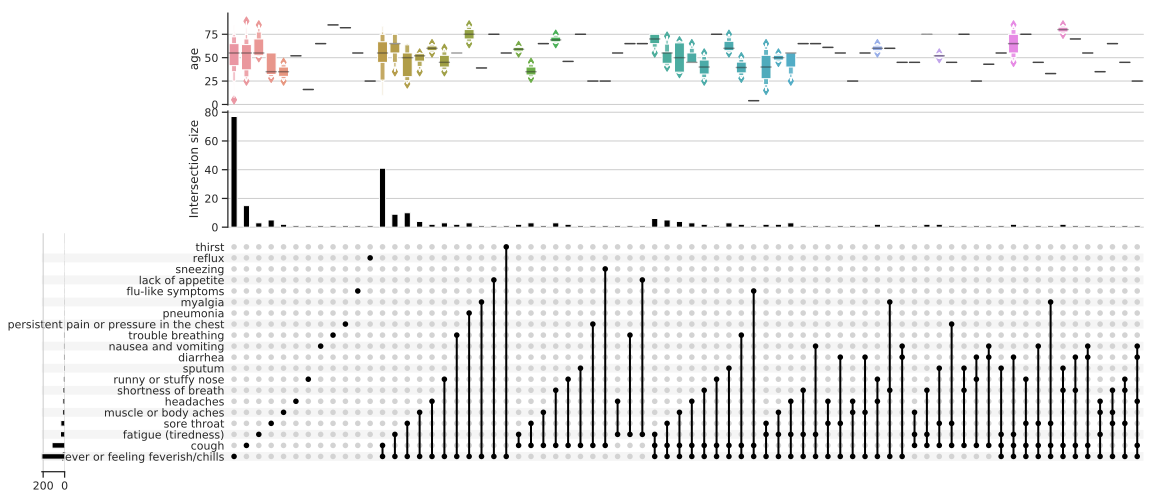

In [85]:
ncov2019_symptom = harmonize_symptoms(ncov2019)
symptoms = ncov2019_symptom.columns.tolist()
symptoms.remove("age")
ncov2019_symptom = ncov2019_symptom.set_index(symptoms)
upset = UpSet(
    ncov2019_symptom, subset_size="count", intersection_plot_elements=10, element_size=16
)
upset.add_catplot(value="age", kind="boxen", elements=8)
upset.plot()
plt.show()

### Caculate the frequencies of sumptoms in nCoV2019 dataset

In [14]:
def caculate_symptoms_presence(dataframe):
    dataframe["symptom"] = dataframe["symptoms"].str.split(",")
    for symptom in set.union(*dataframe.symptom.apply(set)):
        dataframe[symptom] = dataframe.apply(
            lambda _: int(symptom in _.symptom), axis=1
        )
    dataframe = dataframe.drop(["symptoms", "symptom", "age"], axis=1)
    if "no data" in dataframe.columns:
        dataframe = dataframe.drop(["no data"], axis=1)
    else:
        pass
    if "fever* or feeling feverish/chills" in dataframe.columns:
        dataframe = dataframe.drop(["fever* or feeling feverish/chills"], axis=1)
    else:
        pass
    ratio = (dataframe.sum()/dataframe.shape[0]).sort_values(ascending=False)
    return pd.Series(["{0:.2f}%".format(val * 100) for val in ratio], index = ratio.index)

caculate_symptoms_presence(ncov2019)

fever or feeling feverish/chills            78.52%
cough                                       43.33%
fatigue (tiredness)                         14.44%
sore throat                                 12.96%
muscle or body aches                         6.67%
headaches                                    5.93%
shortness of breath                          5.56%
runny or stuffy nose                         4.44%
sputum                                       3.70%
diarrhea                                     3.70%
nausea and vomiting                          2.59%
trouble breathing                            2.22%
persistent pain or pressure in the chest     1.11%
pneumonia                                    1.11%
myalgia                                      1.11%
flu-like symptoms                            0.74%
lack of appetite                             0.74%
sneezing                                     0.37%
reflux                                       0.37%
thirst                         

#### Summary
* Most common symptoms are fever and cough in this dataset.
* Though the total size is 1,083, only 270 patients with symptoms data collected.
* There are a total of 20 symptoms: 

     * Primary symptoms (present in >50% of patients): fever.

     * Symptoms of intermediate incidence (present in 5-49% of patients): cough, fatigue, sore throat, muscle or body aches, headaches, shortness of breath. 
     
     * Rare symptoms (present in <5% of patients): runny or stuffy nose, sputum, diarrhea, nausea and vomiting, trouble breathing, persistent pain or pressure in the chest, pneumonia, myalgia, lack of appetite, flu-like symptoms, reflux, sneezing, thirst.

### Visualize the correlation between symptoms in nCoV2019 dataset

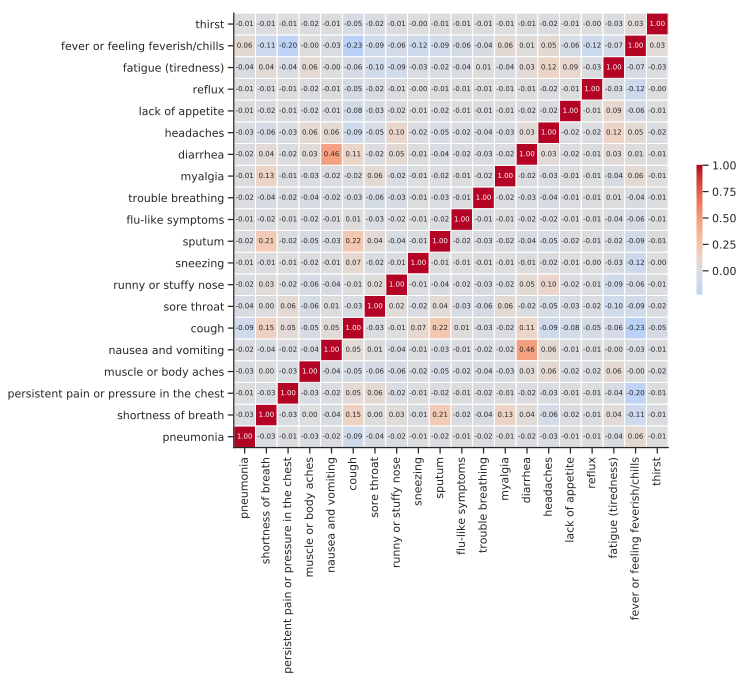

In [86]:
def corr_plot(dataframe):
    dataframe["symptom"] = dataframe["symptoms"].str.split(",")
    for symptom in set.union(*dataframe.symptom.apply(set)):
        dataframe[symptom] = dataframe.apply(
            lambda _: int(symptom in _.symptom), axis=1
        )
    dataframe = dataframe.drop(["symptoms", "symptom", "age"], axis=1)
    if "fever* or feeling feverish/chills" in dataframe.columns:
        dataframe = dataframe.drop(["fever* or feeling feverish/chills"], axis=1)
    else:
        pass
    if "no data" in dataframe.columns:
        dataframe = dataframe.drop(["no data"], axis=1)
    else:
        pass
    corr = dataframe.corr()
    fig = sns.heatmap(
        corr,
        yticklabels=True,
        vmax=1,
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.3},
        annot=True,
        fmt=".2f",
        annot_kws={"size": 7},
        cmap="coolwarm",
    )
    sns.despine()
    fig.figure.set_size_inches(10, 8)
    fig.set_ylim(0, len(dataframe.columns))
    return fig


corr_plot(ncov2019)

#### Summary
* High positive correlation was found between diarrhea and nausea, vomiting. All of them are gastrointestinal symptoms, which may result from remdesivir treatment. 
* Some respiratory symptoms are correlated: shortness of breath is positively correlated with sputum; cough is positively correlated with sputum.
* Slight negative correlation was observed between fever and cough.


### Visualize the combinations of symptoms in DSFSI dataset

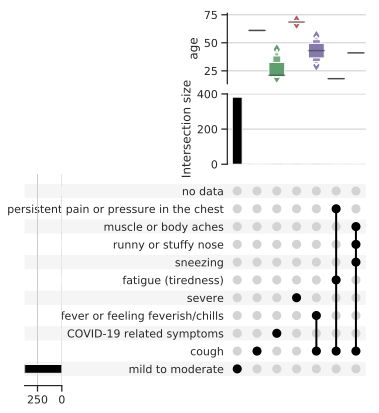

In [87]:
dsfsi_symptom = harmonize_symptoms(dsfsi.loc[dsfsi.symptoms != "no data"])
dsfsi_symptom = dsfsi_symptom.drop(["fever* or feeling feverish/chills"], axis=1)
symptoms = dsfsi_symptom.columns.tolist()
symptoms.remove("age")
dsfsi_symptom = dsfsi_symptom.set_index(symptoms)
upset = UpSet(
    dsfsi_symptom, subset_size="count", intersection_plot_elements=4, element_size=26
)
upset.add_catplot(value="age", kind="boxen", elements=4)
upset.plot()
plt.show()

### Caculate the frequencies of sumptoms in DSFSI dataset

In [9]:
caculate_symptoms_presence(dsfsi.loc[dsfsi.symptoms != "no data"])

mild to moderate                            97.45%
cough                                        1.28%
COVID-19 related symptoms                    0.77%
fever or feeling feverish/chills             0.51%
severe                                       0.51%
runny or stuffy nose                         0.26%
fatigue (tiredness)                          0.26%
sneezing                                     0.26%
persistent pain or pressure in the chest     0.26%
muscle or body aches                         0.26%
dtype: object

#### Summary
* Most common symptom is mild to moderate (97.45%) in this dataset.
* Though the total size is 10,087, only 392 patients with symptoms data collected.
* The symptoms infomation was obtained from different sources (such as Africa CDC and unofficial sources like online News sites). They were not very well harmonized: some sources categorized the symptoms into "mild to moderate" and "severe"; some sources made it general like "COVID-19 related symptoms", which may leads to biased results.    

### Visualize the correlation between symptoms in DSFSI dataset

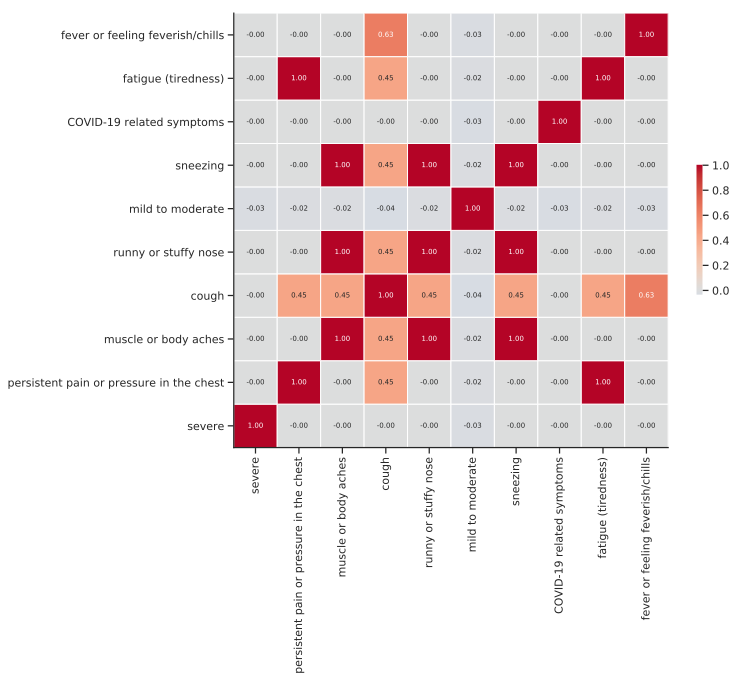

In [88]:
corr_plot(dsfsi)

#### Summary
* A postive correlation was observed between fever and cough, which is opposite to what we found in nCoV2019 dataset.
* Please note the results here could be skewed, since the majority (97.45%) of the symptoms are labelled as "mild to moderate". 

### Harmonize age across datasets

In [25]:
def define_age_decade(dataset):
    dataset.loc[(dataset["age"] < 10), "age_decade"] = "0s"
    dataset.loc[(dataset["age"] < 20) & (dataset["age"] >= 10), "age_decade"] = "10s"
    dataset.loc[(dataset["age"] < 30) & (dataset["age"] >= 20), "age_decade"] = "20s"
    dataset.loc[(dataset["age"] < 40) & (dataset["age"] >= 30), "age_decade"] = "30s"
    dataset.loc[(dataset["age"] < 50) & (dataset["age"] >= 40), "age_decade"] = "40s"
    dataset.loc[(dataset["age"] < 60) & (dataset["age"] >= 50), "age_decade"] = "50s"
    dataset.loc[(dataset["age"] < 70) & (dataset["age"] >= 60), "age_decade"] = "60s"
    dataset.loc[(dataset["age"] < 80) & (dataset["age"] >= 70), "age_decade"] = "70s"
    dataset.loc[(dataset["age"] < 90) & (dataset["age"] >= 80), "age_decade"] = "80s"
    dataset.loc[(dataset["age"] < 100) & (dataset["age"] >= 90), "age_decade"] = "90s"
    dataset.loc[(dataset["age"] >= 100), "age_decade"] = "100s"
    return dataset[dataset.age_decade.notna()]

### Calculate fatality rates
The fatality rate is the number of confirmed deaths divided by the number of confirmed cases.

In [73]:
# Calculate fatality rate for DSFSI
dsfsi_fatality = define_age_decade(DSFSI[["age", "current_state"]])
dsfsi_fatality_percent = (
    dsfsi_fatality.loc[dsfsi_fatality["current_state"] == "deceased"]
    .groupby(["age_decade"])
    .count()
    / dsfsi_fatality.shape[0]
)
dsfsi_fatality_percent = dsfsi_fatality_percent.rename(columns={"age": "fatality_rate"})
dsfsi_fatality_percent = dsfsi_fatality_percent.drop(["current_state"], axis=1)
dsfsi_fatality_percent["dataset"] = "Africa"
# Calculate fatality rate for DSCI
dsci_fatality = define_age_decade(DSCI[["age", "current_state"]])
dsci_fatality_percent = (
    dsci_fatality.loc[dsci_fatality["current_state"] == "deceased"]
    .groupby(["age_decade"])
    .count()
    / dsci_fatality.shape[0]
)
dsci_fatality_percent = dsci_fatality_percent.rename(columns={"age": "fatality_rate"})
dsci_fatality_percent = dsci_fatality_percent.drop(["current_state"], axis=1)
dsci_fatality_percent["dataset"] = "Indonesia"
# Calculate fatality rate for nCoV2019
ncov2019_fatality = define_age_decade(nCOV2019[["age", "death"]])
ncov2019_fatality_percent = (
    ncov2019_fatality.loc[ncov2019_fatality["death"] == True]
    .groupby(["age_decade"])
    .count()
    / ncov2019_fatality.shape[0]
)
ncov2019_fatality_percent = ncov2019_fatality_percent.rename(
    columns={"death": "fatality_rate"}
)
ncov2019_fatality_percent = ncov2019_fatality_percent.drop(["age"], axis=1)
ncov2019_fatality_percent["dataset"] = "nCOV2019"
# Calculate fatality rate for DS4C
ds4c_fatality = DS4C[["age_decade", "current_state"]]
ds4c_fatality_percent = (
    ds4c_fatality.loc[ds4c_fatality["current_state"] == "deceased"].groupby(["age_decade"]).count()
    / ds4c_fatality.shape[0]
)
ds4c_fatality_percent = ds4c_fatality_percent.rename(columns={"current_state": "fatality_rate"})
ds4c_fatality_percent["dataset"] = "South Korea"

### Visualize case fatality rates by age in four datasets

Text(0.5,1,'COVID-19 Fatality Rates by Age')

<Figure size 2000x1600 with 0 Axes>

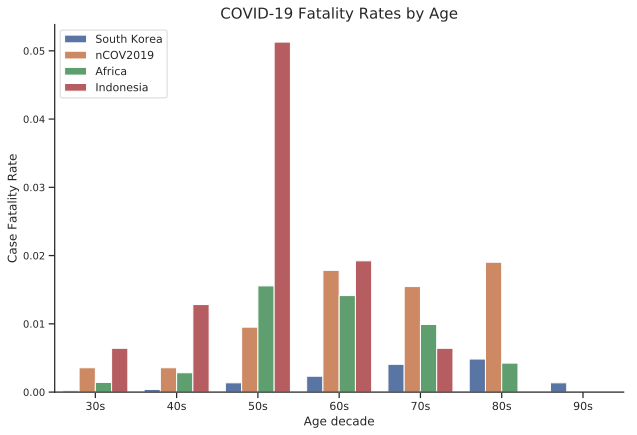

In [89]:
plt.figure(figsize=(10, 8), dpi=200)

data_frames = [
    dsci_fatality_percent,
    dsfsi_fatality_percent,
    ncov2019_fatality_percent,
    ds4c_fatality_percent,
]

fatality_all = reduce(
    lambda left, right: right.append(left, sort=False),
    data_frames,
)

fatality_all["age_decade"] = fatality_all.index
g = sns.catplot(
    x="age_decade",
    y="fatality_rate",
    data=fatality_all.reindex(),
    hue="dataset",
    kind="bar",
    height=6,
    aspect=1.5,
    legend=False,
)
plt.legend()
plt.xlabel("Age decade")
plt.ylabel("Case Fatality Rate")
plt.yticks(fontsize=10)
plt.title("COVID-19 Fatality Rates by Age", fontsize=15)

#### Summary
* We are comparing the fatality rates by age across four datasets in the Chicagoland Pandemic Response Commons.
* Three of the main limitaions to keep in mind when interpreting the fatality rates: 

     * Many cases within the population are unconfirmed due to a lack of testing.
     * Death infomation are not available for every cases in the datasets.
     * Some individuals who are infected will eventually die from the disease, but are still alive at the time of recording.